In [1]:
import numpy as np
import torch
import pandas as pd
import glob
import numpy as np
import pandas as pd
import yaml
import math
import scipy.io as sio
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from pathlib import Path

from plotting import *
from utils import *
from TMP_model import MP_model,TestTMPModel

Model Training

In [2]:

destination_folder = f"../../../data/MMpose/bvh_files/bvh_files_motion_4_walking"
folder_path = "../../../data/MMpose/bvh_files" 
# folder_path = destination_folder  # if specific motion is assumed for trainng only
    # Read BVH files
bvh_data = read_bvh_files(folder_path)
if not bvh_data:
    raise ValueError("No BVH files could be read")

# Process data according to paper specifications
processed_data2 = process_bvh_data(bvh_data)
# a = [torch.tensor(d) for d in processed_data2]
num_segments = len(processed_data2)


# based on TMP code: the format of data=list(segment_data[signals,time]) --> signals are fixed but time 
# could vary in segments
# as far as i underastand:
# num segments = number of videos we have (each subject)
# num_signals =  number of sensors/signals. = number of features / joint infor in data = 54 here
print(f'num of segments : {num_segments}')
num_signals = processed_data2[0].shape[0]
print(f'num of signal : {num_signals}')


num of segments : 18
num of signal : 54


In [44]:
num_MPs = 12  # number of movement primitives
num_t_points= 50

# Initialize model
model2 = MP_model(
    num_t_points=num_t_points,  # number of time discretization points
    num_MPs=num_MPs,
    init_data=processed_data2    # provide initial data
    # init_data= data
)

# Train model
model2.learn(processed_data2, adam_steps=100, bfgs_steps=100)




Initial kernel variance 288.6380240569669
Initial kernel width 9.873412420075004
Learning step 0 at P= -823755010333.9673 , VAF= 0.5890705902108921 , rel. gradient length= 1.0
Learning step 101 at P= -42265261373.16826 , VAF= 0.6090312007987773 , rel. gradient length= 0.2706242470440323
Learning step 102 at P= -41290799836.971375 , VAF= 0.6233831364988216 , rel. gradient length= 0.3514402937384989
Learning step 103 at P= -39994193887.40985 , VAF= 0.607810136476123 , rel. gradient length= 0.43287140119378414
Learning step 104 at P= -30845861247.38925 , VAF= 0.6169646789647202 , rel. gradient length= 0.6024274206297171
Learning step 105 at P= -30503384534.117126 , VAF= 0.6221882200290432 , rel. gradient length= 0.022297849628159547
Learning step 106 at P= -30311789029.040836 , VAF= 0.6191456542791054 , rel. gradient length= 0.26741408336628486
Learning step 107 at P= -26591368470.10558 , VAF= 0.6106338163375403 , rel. gradient length= 0.2711256512782076
Learning step 108 at P= -259596210

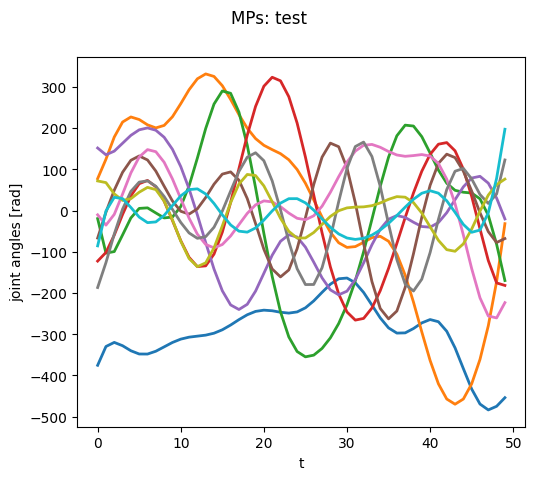

In [40]:

plot_mp(torch.stack(list(model2.MPs)),"test")

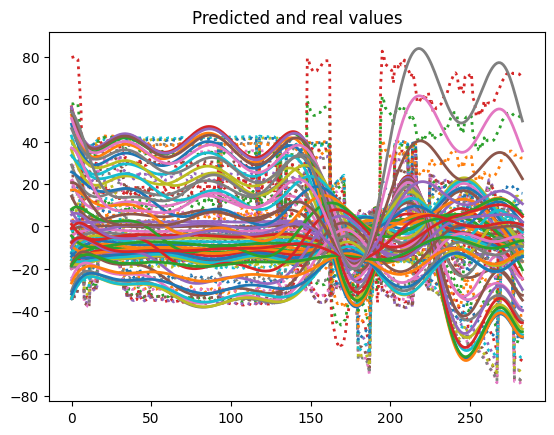

In [42]:

# Make predictions
segment_lengths = [segment.shape[1] for segment in processed_data2]
predictions2 = model2.predict(segment_lengths,as_numpy=True)
index = 9
real = processed_data2[index]
for i in range(real.shape[0]):
    plt.plot(real[i], linewidth=2, linestyle="dotted",label="data")
predicted = predictions2[index]
for i in range(predicted.shape[0]):
   plt.plot(predicted[i], linewidth=2,label="model")
plt.title("Predicted and real values")
# plt.legend()
plt.show()

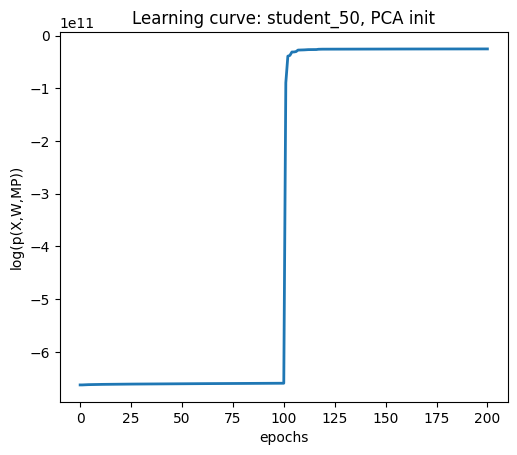

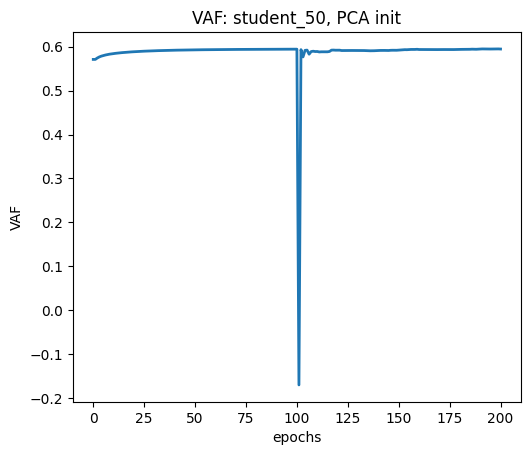

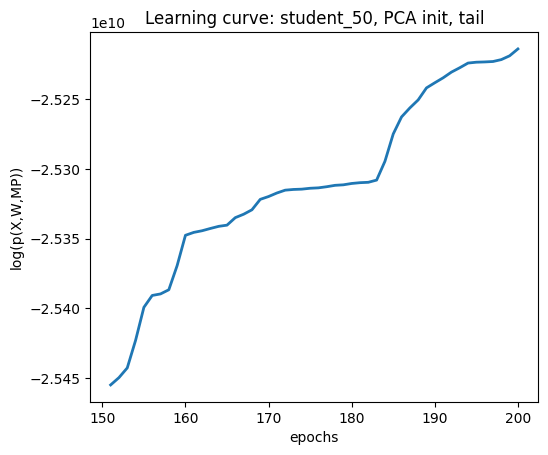

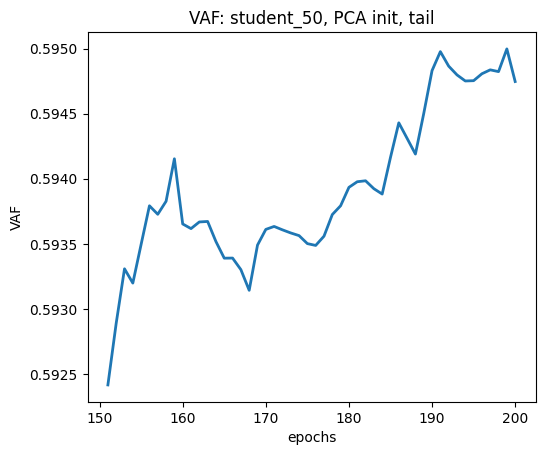

In [43]:
lc=model2.learn_curve
vc=model2.VAF_curve
epochs=numpy.arange(len(lc))

plot_learn_curve(epochs,lc,vc,"student_{0:d}, PCA init".format(50))
plot_learn_curve(epochs[-50:],lc[-50:],vc[-50:],"student_{0:d}, PCA init, tail".format(50))


In [8]:
# model.noise_model
# model.MPs
n = model2.weights
n

# we have a list with num_segment elements (different subjects), each have array of [num_signal* num_MPs]

ParameterList(
    (0): Parameter containing: [torch.float64 of size 54x5]
    (1): Parameter containing: [torch.float64 of size 54x5]
    (2): Parameter containing: [torch.float64 of size 54x5]
    (3): Parameter containing: [torch.float64 of size 54x5]
    (4): Parameter containing: [torch.float64 of size 54x5]
    (5): Parameter containing: [torch.float64 of size 54x5]
    (6): Parameter containing: [torch.float64 of size 54x5]
    (7): Parameter containing: [torch.float64 of size 54x5]
    (8): Parameter containing: [torch.float64 of size 54x5]
    (9): Parameter containing: [torch.float64 of size 54x5]
    (10): Parameter containing: [torch.float64 of size 54x5]
    (11): Parameter containing: [torch.float64 of size 54x5]
    (12): Parameter containing: [torch.float64 of size 54x5]
    (13): Parameter containing: [torch.float64 of size 54x5]
    (14): Parameter containing: [torch.float64 of size 54x5]
    (15): Parameter containing: [torch.float64 of size 54x5]
    (16): Parameter

In [13]:
def plot_weights_for_signal(model, signal_idx, title=None):
    """
    Plot weights of a specific signal for all MPs across all segments.
    
    Parameters:
    -----------
    model : MP_model
        The trained temporal movement primitive model
    signal_idx : int
        Index of the signal to plot (0-53)
    title : str, optional
        Title for the plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get number of segments and MPs
    num_segments = len(model.weights)
    num_MPs = model.num_MPs
    
    # Create figure
    plt.figure(figsize=(8, 4))
    
    # For each MP, collect weights from all segments for the chosen signal
    for mp_idx in range(num_MPs):
        # Extract weights for this MP and signal across all segments
        weights = [model.weights[seg_idx][signal_idx, mp_idx].item() for seg_idx in range(num_segments)]
        
        # Create x positions for this MP (add small jitter to separate points)
        x_positions = np.random.normal(mp_idx + 1, 0.05, len(weights))
        
        # Plot points for this MP
        plt.scatter(x_positions, weights, label=f'MP {mp_idx+1}', alpha=0.7)
    
    # Add a horizontal line at y=0 for reference
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Set plot labels and title
    plt.xlabel('Movement Primitive (MP)')
    plt.ylabel(f'Weight for Signal {signal_idx+1}')
    if title:
        plt.title(title)
    else:
        plt.title(f'Weights for Signal(joint) {signal_idx+1} Across All subjects/segments')
    
    # Set x-ticks to MP numbers
    plt.xticks(range(1, num_MPs + 1))
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [30]:
def train_model(data_dir, motion_label):
    folder_path = data_dir
    bvh_data = read_bvh_files(folder_path)
    processed_data = process_bvh_data(bvh_data)
    num_segments = len(processed_data)
    num_signals = processed_data[0].shape[0]

    num_MPs = 5  
    num_t_points= 50

    model = MP_model(
    num_t_points=num_t_points,  
    num_MPs=num_MPs,
    init_data=processed_data    
    )

    model.learn(processed_data, adam_steps=100, bfgs_steps=100)

    plot_mp(torch.stack(list(model.MPs)),motion_label)

    segment_lengths = [segment.shape[1] for segment in processed_data]
    # predictions = model.predict(segment_lengths,as_numpy=True)
    # index = 9
    # real = processed_data[index]
    # for i in range(real.shape[0]):
    #     plt.plot(real[i], linewidth=2, linestyle="dotted",label="data")
    # predicted = predictions[index]
    # for i in range(predicted.shape[0]):
    #     plt.plot(predicted[i], linewidth=2,label="model")
    #     plt.title("Predicted and real values")
    #     plt.show()
    return(model)

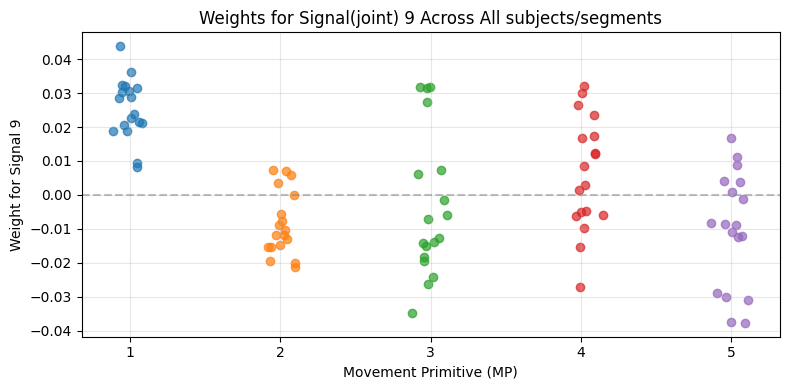

In [14]:
# Choose a signal index (0-53)
signal_idx = 8  # This would be the 6th signal (0-indexed)

# Plot weights for the chosen signal
plot_weights_for_signal(model2, signal_idx)

In [15]:
def identify_signals(num_signals=54):
    """
    Create a mapping between signal indices and joint names with rotation/position axes
    based on Human3.6M keypoint structure.
    
    Parameters:
    -----------
    num_signals : int
        Total number of signals (default=54)
    
    Returns:
    --------
    signal_names : list
        List of signal names in format "JointName_Axis"
    signal_mapping : dict
        Dictionary mapping signal indices to signal names
    """
    # Human3.6M keypoint names
    H36M_KEYPOINT_NAMES = [
        'Hip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle',
        'Spine', 'Thorax', 'Neck', 'Head',
        'LShoulder', 'LElbow', 'LWrist', 'RShoulder', 'RElbow', 'RWrist'
    ]
    
    # Create signal names
    signal_names = []
    signal_mapping = {}
    
    signal_idx = 0
    
    # Hip has 6 signals: X/Y/Z position and Z/X/Y rotation
    hip_signals = ['Xposition', 'Yposition', 'Zposition', 'Zrotation', 'Xrotation', 'Yrotation']
    for signal in hip_signals:
        signal_name = f"Hip_{signal}"
        signal_names.append(signal_name)
        signal_mapping[signal_idx] = signal_name
        signal_idx += 1
    
    # All other joints have 3 rotation signals: Z/X/Y rotation
    rotation_signals = ['Zrotation', 'Xrotation', 'Yrotation']
    for joint in H36M_KEYPOINT_NAMES[1:]:  # Skip Hip as it's already processed
        for signal in rotation_signals:
            signal_name = f"{joint}_{signal}"
            signal_names.append(signal_name)
            signal_mapping[signal_idx] = signal_name
            signal_idx += 1
    
    # Verify we have the expected number of signals
    expected_signals = 6 + (len(H36M_KEYPOINT_NAMES) - 1) * 3  # 6 for Hip + 3 for each other joint
    
    if expected_signals != num_signals:
        print(f"Warning: Expected {expected_signals} signals based on H36M structure.")
        print(f"Actual number of signals: {num_signals}")
        
        # Fill any remaining indices if needed
        for i in range(signal_idx, num_signals):
            signal_name = f"Unknown_{i}"
            signal_names.append(signal_name)
            signal_mapping[i] = signal_name
    
    return signal_names, signal_mapping

In [31]:
def plot_weights_by_joint(model, motion_label):
    """
    Plot weight distribution for all signals grouped by joint, with one subplot per MP.
    
    Parameters:
    -----------
    model : MP_model
        The trained temporal movement primitive model
    title : str, optional
        Title for the plot
    """
    # Get dimensions
    num_segments = len(model.weights)
    num_MPs = model.num_MPs
    num_signals = model.weights[0].shape[0]
    
    # Get signal names and mapping
    signal_names, signal_mapping = identify_signals(num_signals)
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_MPs, 1, figsize=(18, 4*num_MPs), sharex=True)
    if num_MPs == 1:
        axes = [axes]  # Make it iterable for a single subplot
    
    # Define colors for different signal types
    signal_colors = {
        'Xposition': 'tab:red',
        'Yposition': 'tab:green',
        'Zposition': 'tab:blue',
        'Zrotation': 'tab:purple',
        'Xrotation': 'tab:orange',
        'Yrotation': 'tab:brown'
    }
    
    # For each MP
    for mp_idx in range(num_MPs):
        ax = axes[mp_idx]
        
        # For each signal, collect weights from all segments
        for signal_idx in range(num_signals):
            signal_name = signal_mapping[signal_idx]
            signal_type = signal_name.split('_')[1]
            
            # Extract weights for this MP and signal across all segments
            weights = [model.weights[seg_idx][signal_idx, mp_idx].item() for seg_idx in range(num_segments)]
            
            # Create x positions for this signal
            x_positions = np.random.normal(signal_idx + 1, 0.1, len(weights))
            
            # Plot points for this signal
            ax.scatter(x_positions, weights, alpha=0.6, s=30, color=signal_colors.get(signal_type, 'gray'))
        
        # Add a horizontal line at y=0 for reference
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Set plot labels
        ax.set_ylabel(f'Weights for MP {mp_idx+1}')
        ax.set_title(f'Movement Primitive {mp_idx+1} Weight Distribution')
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
    
    # Add common x label
    plt.xlabel('Joint Signal')
    
    # Create custom x-tick labels
    tick_positions = list(range(1, num_signals + 1))
    tick_labels = [f"{signal_idx+1}: {name}" for signal_idx, name in signal_mapping.items()]
    
    # Use every few ticks to avoid overcrowding
    step = max(1, num_signals // 20)
    plt.xticks(tick_positions[::step], tick_labels[::step], rotation=45, ha='right', fontsize=8)
    
    # Add a legend for signal types
    legend_elements = [Patch(facecolor=color, label=signal_type) 
                      for signal_type, color in signal_colors.items()]
    fig.legend(handles=legend_elements, loc='upper right', title='Signal Types')
    
    fig.suptitle(f'Weight Distribution by Joint in {motion_label}', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.2)  # Adjust to make room for the suptitle and rotated labels
    plt.savefig(f'weights_{motion_label}.png')
    plt.show()

Processed segment shape: (54, 177)
Processed segment shape: (54, 307)
Processed segment shape: (54, 249)
Processed segment shape: (54, 421)
Processed segment shape: (54, 229)
Processed segment shape: (54, 274)
Processed segment shape: (54, 301)
Processed segment shape: (54, 271)
Processed segment shape: (54, 253)
Processed segment shape: (54, 272)
Processed segment shape: (54, 236)
Processed segment shape: (54, 278)
Processed segment shape: (54, 215)
Processed segment shape: (54, 314)
Processed segment shape: (54, 343)
Processed segment shape: (54, 238)
Processed segment shape: (54, 93)
Processed segment shape: (54, 275)
Initial kernel variance 367.4816007610876
Initial kernel width 6.2968910293452
Learning step 0 at P= -145073355777.59082 , VAF= 0.47767932059738205 , rel. gradient length= 1.0
Learning step 101 at P= -30222235185.55099 , VAF= 0.48414377076878434 , rel. gradient length= 0.018723438420053036
Learning step 102 at P= -29735194300.901546 , VAF= 0.4837758679859394 , rel. gra

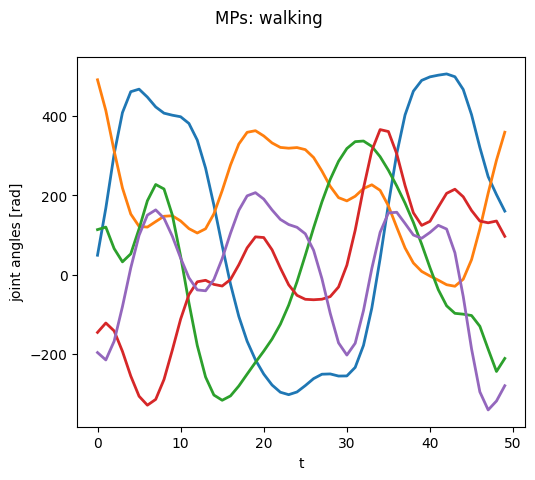

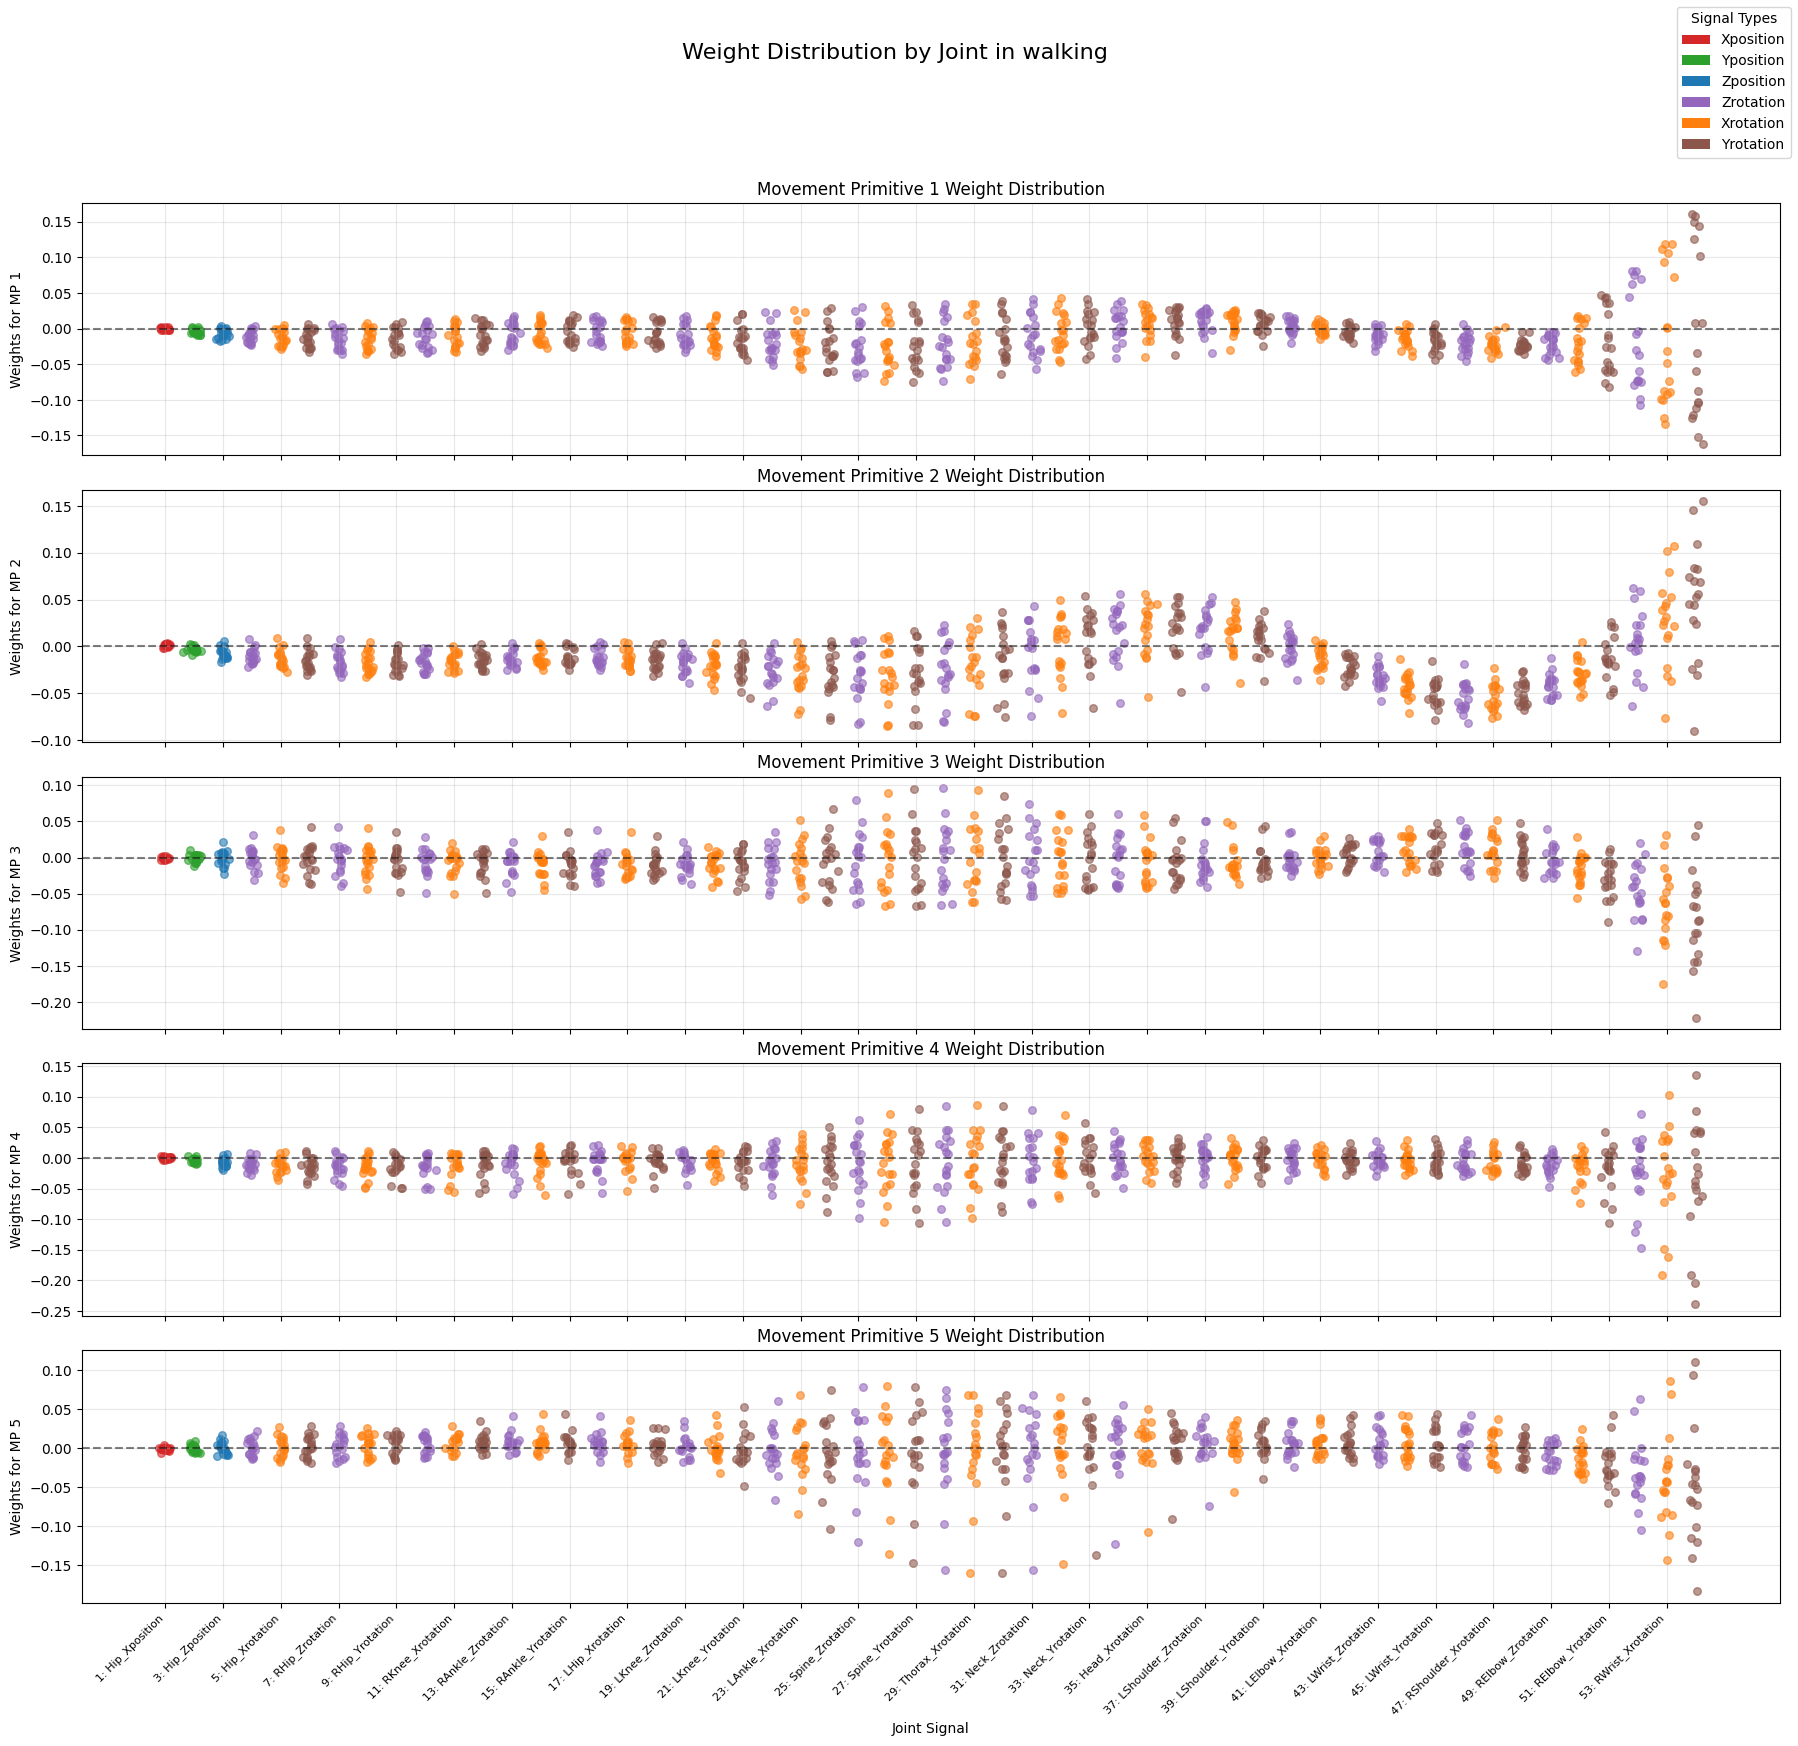

In [32]:
# i want to compare weight distribution among two movement
data_dir = "../../../data/MMpose/bvh_files/bvh_files_motion_2_walking"
motion_label = "walking"
model = train_model(data_dir, motion_label)
plot_weights_by_joint(model, motion_label)


Processed segment shape: (54, 125)
Processed segment shape: (54, 187)
Processed segment shape: (54, 178)
Processed segment shape: (54, 73)
Processed segment shape: (54, 200)
Processed segment shape: (54, 63)
Processed segment shape: (54, 123)
Processed segment shape: (54, 120)
Processed segment shape: (54, 106)
Processed segment shape: (54, 79)
Processed segment shape: (54, 67)
Processed segment shape: (54, 82)
Processed segment shape: (54, 104)
Processed segment shape: (54, 115)
Processed segment shape: (54, 78)
Processed segment shape: (54, 75)
Processed segment shape: (54, 97)
Processed segment shape: (54, 74)
Initial kernel variance 188.21501059020173
Initial kernel width 13.409632446631374
Learning step 0 at P= -143531818389.55978 , VAF= 0.49487539950574677 , rel. gradient length= 1.0
Learning step 101 at P= -13280464269.083426 , VAF= -0.027433090303141672 , rel. gradient length= 32.92757867250577
Learning step 102 at P= -7101361053.748679 , VAF= 0.49474977757940053 , rel. gradien

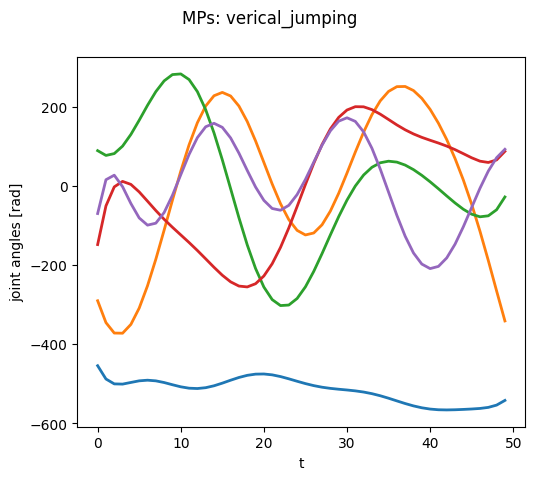

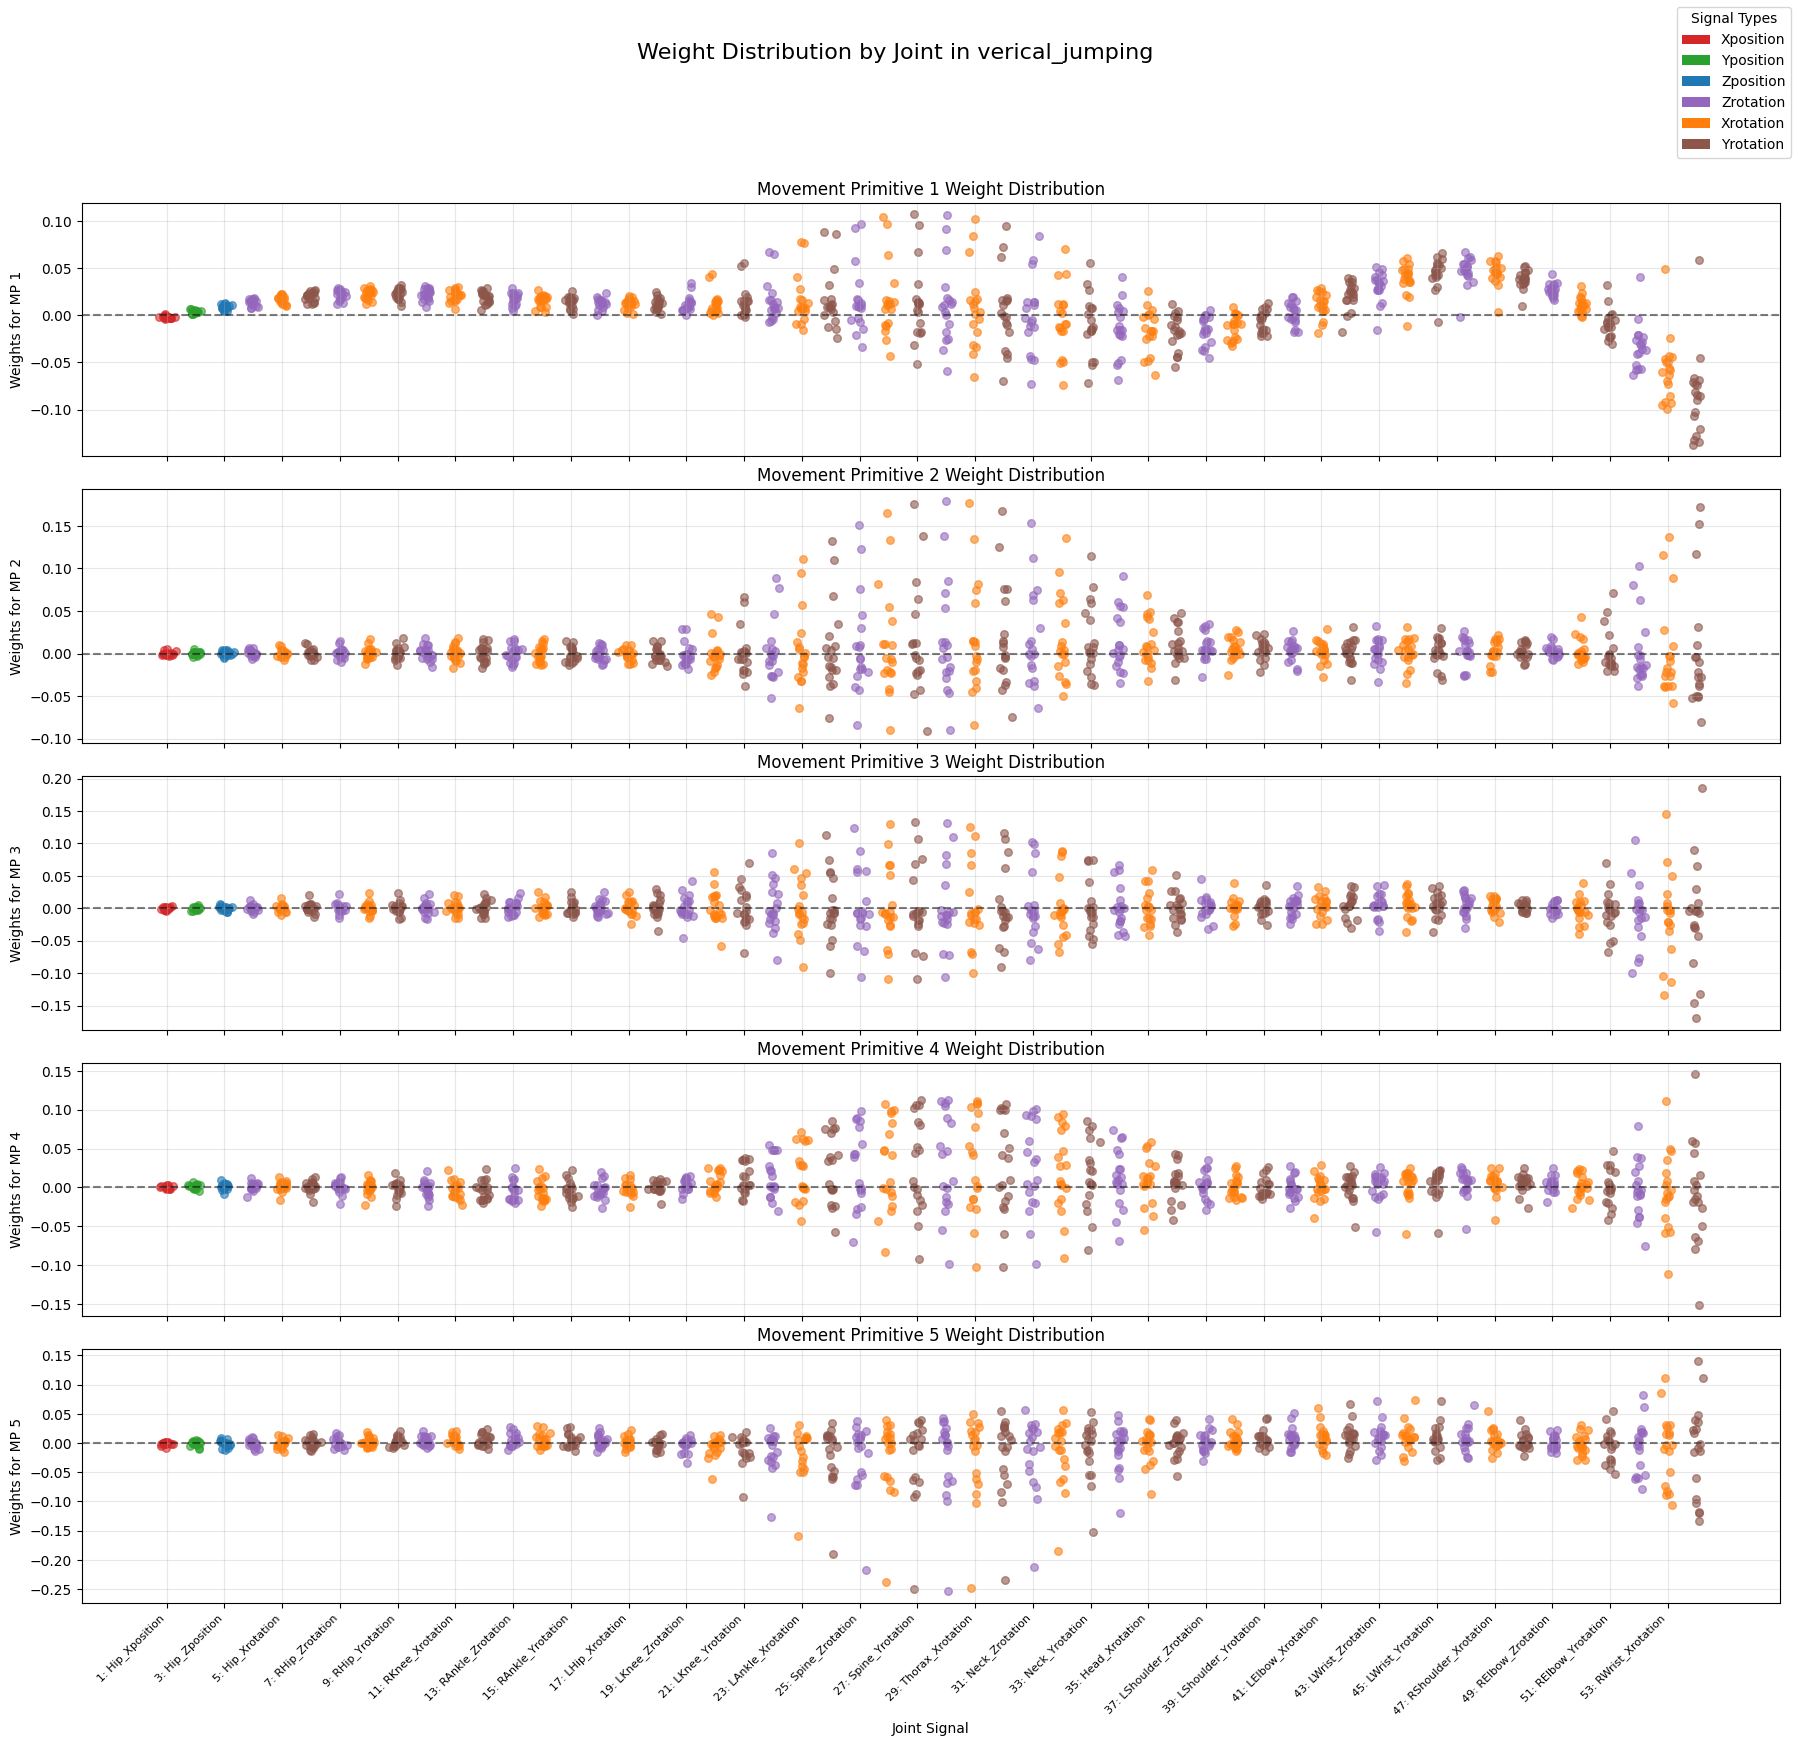

In [33]:
data_dir = "../../../data/MMpose/bvh_files/bvh_files_motion_4_vertical_jumping"
motion_label = "verical_jumping"
model = train_model(data_dir, motion_label)
plot_weights_by_joint(model, motion_label)

Processed segment shape: (54, 91)
Processed segment shape: (54, 96)
Processed segment shape: (54, 71)
Processed segment shape: (54, 99)
Processed segment shape: (54, 78)
Processed segment shape: (54, 89)
Processed segment shape: (54, 89)
Processed segment shape: (54, 61)
Processed segment shape: (54, 94)
Processed segment shape: (54, 113)
Processed segment shape: (54, 162)
Processed segment shape: (54, 85)
Processed segment shape: (54, 117)
Processed segment shape: (54, 75)
Processed segment shape: (54, 67)
Processed segment shape: (54, 107)
Processed segment shape: (54, 105)
Processed segment shape: (54, 88)
Initial kernel variance 138.22542026240498
Initial kernel width 11.90204719198834
Learning step 0 at P= -109957366041.3847 , VAF= 0.563275162491566 , rel. gradient length= 1.0
Learning step 101 at P= -4517664173.731884 , VAF= 0.5614462311044297 , rel. gradient length= 0.6158991050761305
Learning step 102 at P= -4429199585.621828 , VAF= 0.5576960192099356 , rel. gradient length= 1.

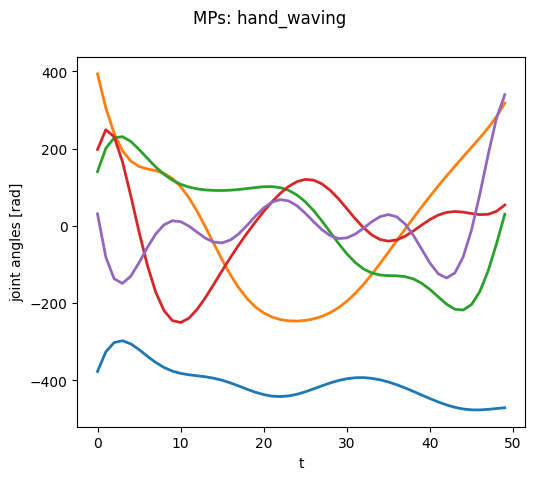

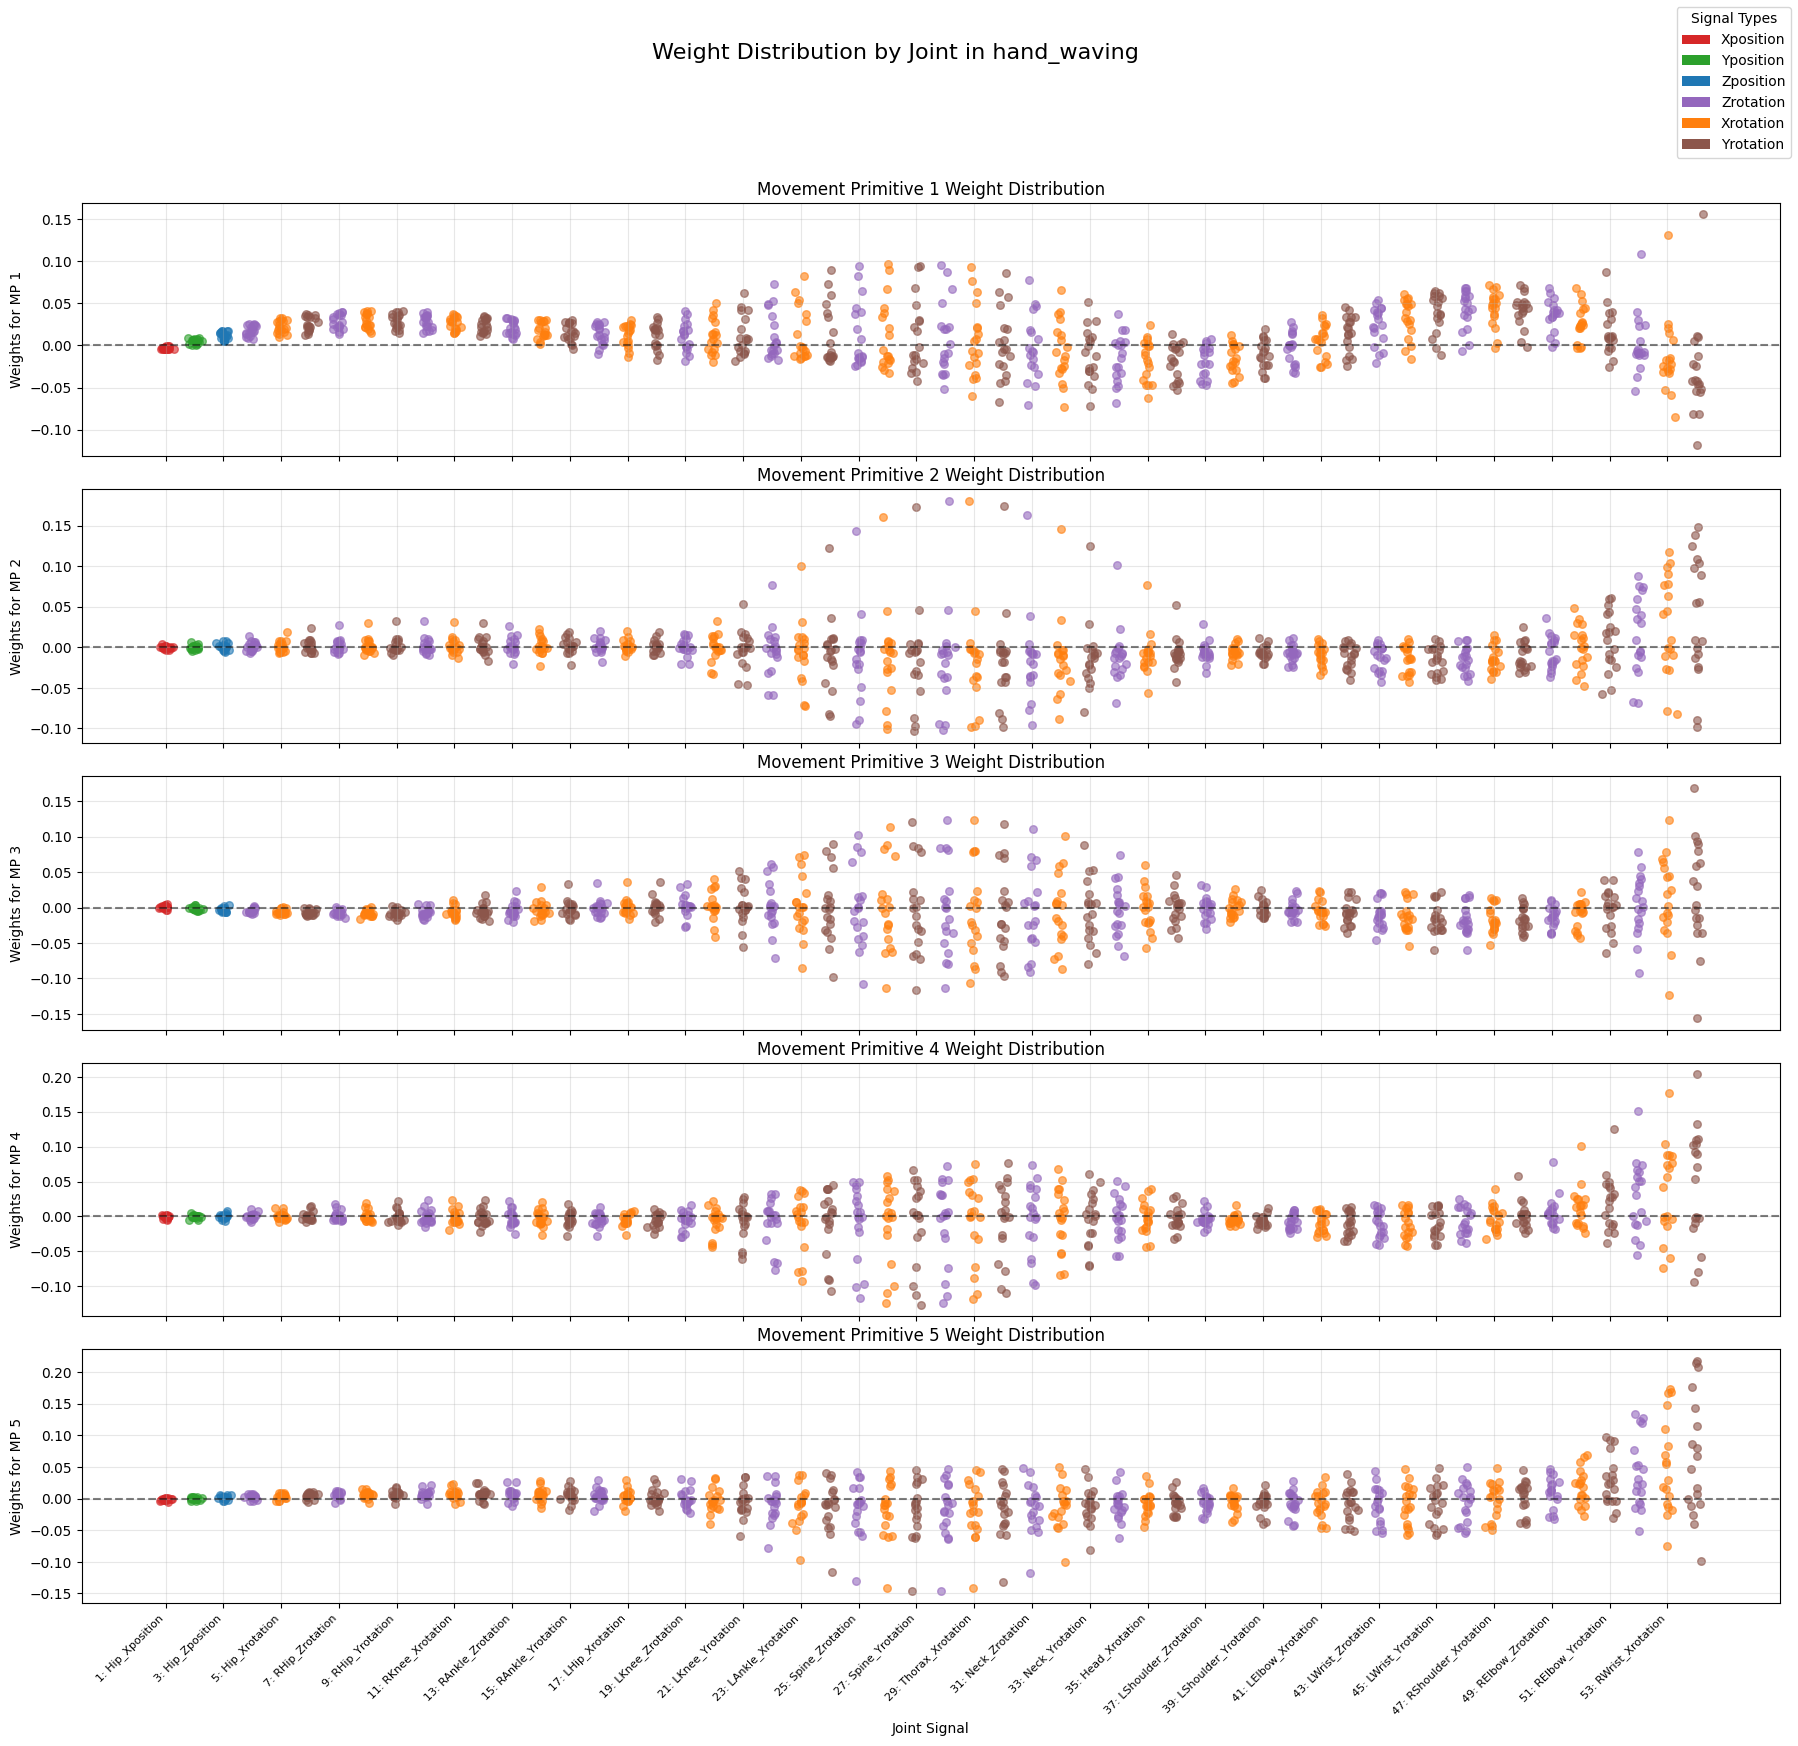

In [34]:
data_dir = "../../../data/MMpose/bvh_files/bvh_files_motion_6_hand_waving"
motion_label = "hand_waving"
model = train_model(data_dir, motion_label)
plot_weights_by_joint(model, motion_label)

#8_checking_watch
#5_crawling

Processed segment shape: (54, 233)
Processed segment shape: (54, 530)
Processed segment shape: (54, 368)
Processed segment shape: (54, 490)
Processed segment shape: (54, 408)
Processed segment shape: (54, 204)
Processed segment shape: (54, 277)
Processed segment shape: (54, 284)
Processed segment shape: (54, 301)
Processed segment shape: (54, 290)
Processed segment shape: (54, 350)
Processed segment shape: (54, 136)
Processed segment shape: (54, 308)
Processed segment shape: (54, 334)
Processed segment shape: (54, 367)
Processed segment shape: (54, 321)
Processed segment shape: (54, 407)
Processed segment shape: (54, 373)
Initial kernel variance 389.44579975177385
Initial kernel width 8.19270539083867
Learning step 0 at P= -157168867707.4215 , VAF= 0.5455213998792396 , rel. gradient length= 1.0
Learning step 101 at P= -34768958400.60076 , VAF= 0.548036677814407 , rel. gradient length= 0.4858958144977732
Learning step 102 at P= -34680385481.86803 , VAF= 0.5487999984698962 , rel. gradien

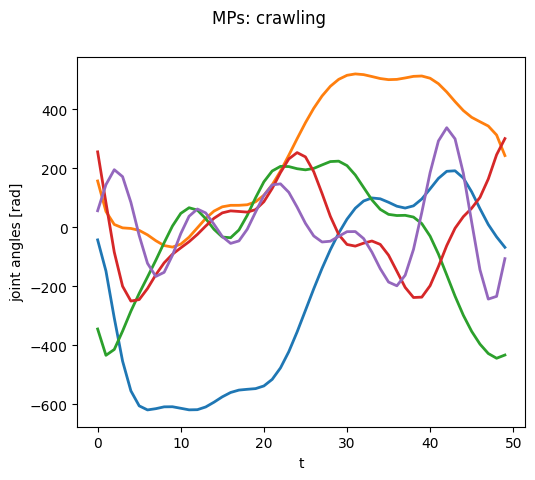

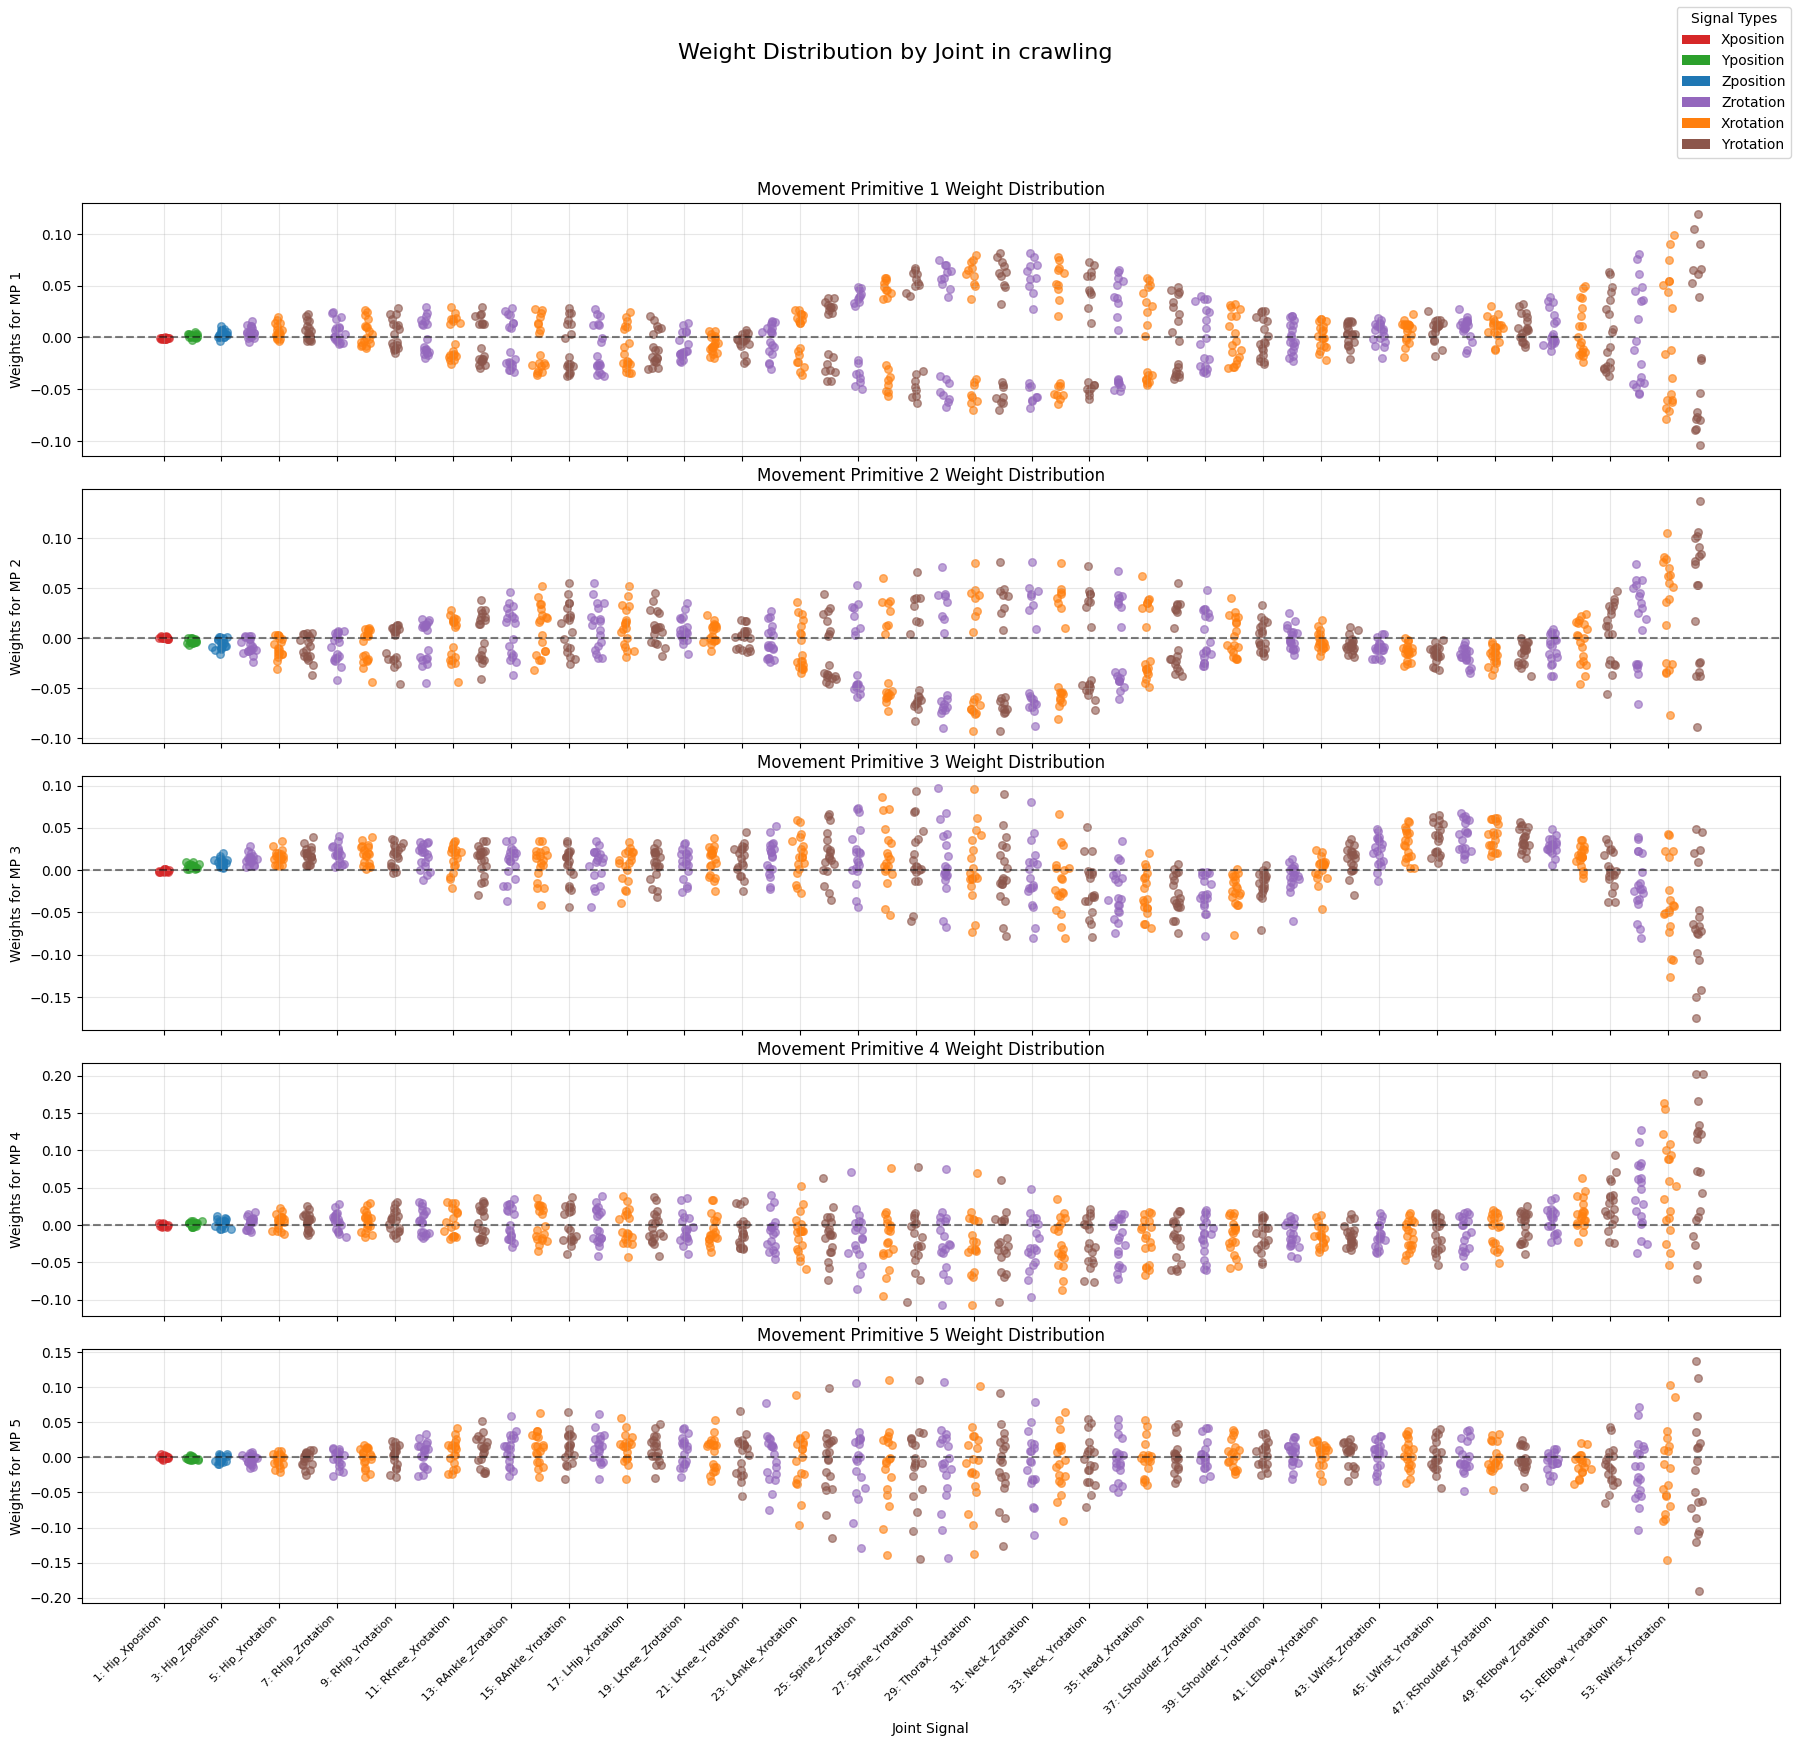

In [35]:
data_dir = "../../../data/MMpose/bvh_files/bvh_files_motion_5_crawling"
motion_label = "crawling"
model = train_model(data_dir, motion_label)
plot_weights_by_joint(model, motion_label)